# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_{x} \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [ ]:
# Funzioni ausiliarie

def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

In [ ]:
# Importazione delle librerie

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from skimage import data, filters
from PIL import Image
import requests
from io import BytesIO

# Dichiarazione delle variabili

url = 'https://cdn.discordapp.com/attachments/675275973918195712/797063040440598538/IMG1.png'
# url = 'https://cdn.discordapp.com/attachments/675275973918195712/797093500625354832/IMG2.png'
# url = 'https://cdn.discordapp.com/attachments/675275973918195712/797098444350029826/IMG3.png'

sigmaS = 0.5
d = 7
sigmaR = 0.1

In [ ]:
# 1 Test

response = requests.get(url)
X = Image.open(BytesIO(response.content))
X = np.array(X)
if len(X.shape) == 3:
  X = X[:, :, 1]
m, n = X.shape
x = X.reshape(m*n)

In [ ]:
# 1

X = data.camera()
m, n = X.shape
x = X.reshape(m * n)

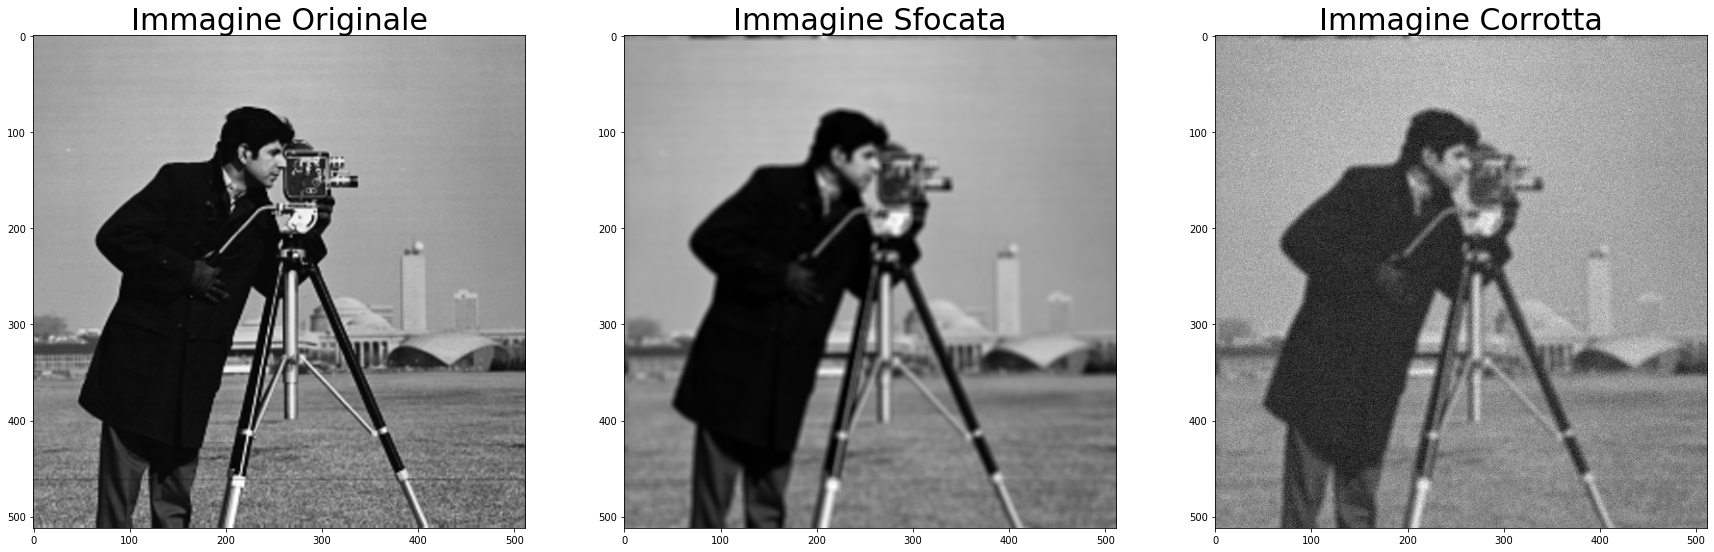

In [ ]:
# 2

X_blur = A(X, d, sigmaS)
x_blur = X_blur.reshape(m * n)

# 3

eta = np.random.normal(size=X_blur.shape)
eta /= np.linalg.norm(eta, 'fro')
eta *= sigmaR * np.linalg.norm(X_blur,'fro')

B = X_blur + eta
b = B.reshape(m*n)

# Plot dei risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

In [ ]:
# 4

def f(X):
  arg = A(X) - B
  return 1/2 * (linalg.norm(arg, 'fro') ** 2) 

def grad_f(X):
  return AT(A(X) - B)

def backtracking(x, grad):
  alpha = 1.1
  beta = 0.5
  gamma = 0.25
  i = 1
  while f(x - alpha * grad) > (f(x) - alpha * gamma * (linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * beta
    i += 1
  return alpha

def minimize(x0, MAXITERATION, ABSOLUTE_STOP):
  x_old = x0
  grad = grad_f(x0)
  error = np.zeros((MAXITERATION, 1))
  k = 0

  while np.linalg.norm(grad, 'fro') > ABSOLUTE_STOP and k < MAXITERATION - 1:
    step = backtracking(x_old, grad)
    x_new = x_old - step * grad
    grad = grad_f(x_new)
    error[k] = linalg.norm(x_old - X, 2) / linalg.norm(X, 2)

    x_old = x_new
    k += 1
  
  return (x_new, error[: k])

In [ ]:
# Calcolo dell'immagine con il metodo di discesa del gradiente
MAXITERATION = 100
ABSOLUTE_STOP = 1.e-5
x_init = B
x_naive, error = minimize(x_init, MAXITERATION, ABSOLUTE_STOP)

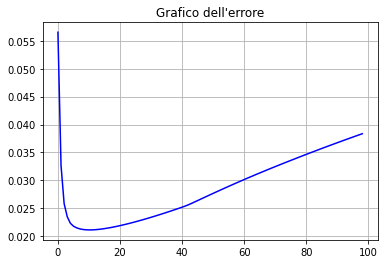

L'errore relativo minimo dell'immagine è all'iterazione 11


In [ ]:
# 5

# Plot dell'errore sulle varie iterazioni
plt.title("Grafico dell'errore")
plt.plot(error, color = 'blue')
plt.grid()
plt.show()

# Calcolo della semiconvergenza
k = np.argmin(error)
print('L\'errore relativo minimo dell\'immagine è all\'iterazione ' + str(k + 1))
x_trunc, _ = minimize(x_init, k, ABSOLUTE_STOP)

In [ ]:
# 6

def f2(X, lmbd):
  arg = A(X) - B
  return 1/2 * (linalg.norm(arg, 'fro') ** 2) + (linalg.norm(X, 'fro') ** 2) * lmbd / 2 

def grad_f2(X, lmbd):
  return AT(A(X) - B) + lmbd * X

def backtracking2(x, grad, lmbd):
  alpha = 1.1
  beta = 0.5
  gamma = 0.25
  i = 1
  while f2(x - alpha * grad, lmbd) > (f2(x, lmbd) - alpha * gamma * (linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * beta
    i += 1
  return alpha

def minimize2(x0, MAXITERATION, ABSOLUTE_STOP, lmbd):
  x_old = x0
  grad = grad_f2(x0, lmbd)
  k = 0

  while np.linalg.norm(grad, 'fro') > ABSOLUTE_STOP and k < MAXITERATION - 1:
    step = backtracking2(x_old, grad, lmbd)
    x_new = x_old - step * grad
    grad = grad_f2(x_new, lmbd)
    error = linalg.norm(x_old - X, 2) / linalg.norm(X, 2)

    # L'algoritmo di ferma al primo valore minimo
    if error < linalg.norm(x_new - X, 2) / linalg.norm(X, 2):
      return (x_old, error)

    x_old = x_new
    k += 1

  return (x_old, error)

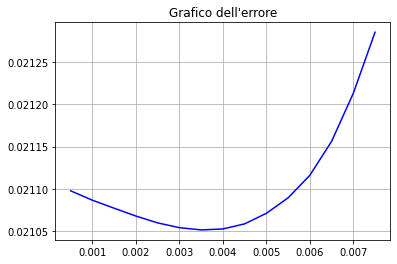

Il valore di lambda è: [0.0035]


In [ ]:
# Calcolo dell'errore al variare di lambda
MAXITERATION = 100
ABSOLUTE_STOP = 1.e-5
x_init = B
length = 15
start = 0.0005
lmbds = np.zeros((length, 1))
errors = np.zeros((length, 1))
x_lmbds = np.zeros((length, m, n))

for i in range(0, length):
  lmbds[i] = start * (i + 1)
  x_lmbds[i, :, :], errors[i] = minimize2(x_init, MAXITERATION, ABSOLUTE_STOP, lmbds[i])

# Plot dell'errore al variare di lambda
plt.title("Grafico dell'errore")
plt.plot(lmbds, errors, color = 'blue')
plt.grid()
plt.show()

# Calcolo del valore ottimale di lambda
k = np.argmin(errors)
lmbd = lmbds[k]
print('Il valore di lambda è: ' + str(lmbd))
x_lmbd = x_lmbds[k]

In [ ]:
# 7

# Calcolo di lambda col principio di discrepanza
def arg_1(lmbd):
  x_lmbd, _ = minimize2(x_init, MAXITERATION, ABSOLUTE_STOP, lmbd)
  return linalg.norm(A(x_lmbd) - B, 'fro') ** 2

arg_2 = linalg.norm(eta, 'fro') ** 2
lmbd = 0.005

while arg_1(lmbd) <= arg_2:
  lmbd += 0.005

disc_lmbd = lmbd - 0.005
print('Il valore di lambda è: ' + str(disc_lmbd))
x_disc_lmbd, _ = minimize2(x_init, MAXITERATION, ABSOLUTE_STOP, disc_lmbd)

Il valore di lambda è: 0.030000000000000002


In [ ]:
# 8

def f3(X, lmbd):
  arg = A(X) - B
  return 1/2 * (linalg.norm(arg, 'fro') ** 2) + (linalg.norm(X, 1)) * lmbd  

def grad_f3(X, lmbd):
  return AT(A(X) - B) + lmbd * np.sign(X)

def backtracking3(x, grad, lmbd):
  alpha = 1.1
  beta = 0.5
  gamma = 0.25
  i = 1
  while f3(x - alpha * grad, lmbd) > (f3(x, lmbd) - alpha * gamma * (linalg.norm(grad, 'fro') ** 2)):
    alpha = alpha * beta
    i += 1
  return alpha

def minimize3(x0, MAXITERATION, ABSOLUTE_STOP, lmbd):
  x_old = x0
  grad = grad_f3(x0, lmbd)
  k = 0

  while np.linalg.norm(grad, 'fro') > ABSOLUTE_STOP and k < MAXITERATION - 1:
    step = backtracking3(x_old, grad, lmbd)
    x_new = x_old - step * grad
    grad = grad_f3(x_new, lmbd)
    error = linalg.norm(x_old - X, 2) / linalg.norm(X, 2)

    if error < linalg.norm(x_new - X, 2) / linalg.norm(X, 2):
      return (x_old, error)

    x_old = x_new
    k += 1

  return (x_old, error)

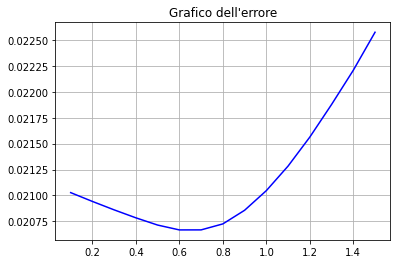

Il valore ottimale di lambda è: 0.6000000000000001


In [ ]:
# Calcolo dell'errore al variare di lambda
MAXITERATION = 100
ABSOLUTE_STOP = 1.e-5
x_init = B
length = 15
start = 0.1
lmbds = np.zeros((length, 1))
errors = np.zeros((length, 1))
x_lmbds = np.ones((length, m, n))

for i in range(0, length):
  lmbds[i] = start * (i + 1)
  x_lmbds[i, :, :], errors[i] = minimize3(x_init, MAXITERATION, ABSOLUTE_STOP, lmbds[i])

# Plot dell'errore al variare di lambda
plt.title("Grafico dell'errore")
plt.plot(lmbds, errors, color = 'blue')
plt.grid()
plt.show()

# Calcolo del valore ottimale di lambda
k = np.argmin(errors)
print('Il valore ottimale di lambda è: ' + str((k + 1) * start))
x_lmbd_1 = x_lmbds[k]

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


In [ ]:
# Funzione per il calcolo dell'errore relativo rispetto alla soluzione esatta
def err_rel(img1, img2):
  return linalg.norm(img2 - img1, 2) / linalg.norm(img1, 2)

# Funzione per il calcolo del PSNR
def psnr(img1, img2):
  mse = np.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

In [ ]:
# Immagini calcolate

testo = [
         'Metodo di discesa',
         'Metodo di discesa utilizzando l\'iterato ottimo',     
         'Metodo di discesa utilizzando l\'iterato ottimo e il parametro di regolarizzazione',
         'Metodo di discesa utilizzando l\'iterato ottimo, il parametro di regolarizzazione e il principio di discrepanza',
         'Metodo di discesa utilizzando l\'iterato ottimo, il parametro di regolarizzazione in norma 1'
]

immagini = [
            x_naive,
            x_trunc,
            x_lmbd,
            x_disc_lmbd,
            x_lmbd_1
]

for i in range(0, 5):
  print(testo[i])
  plt.figure(figsize=(30, 10))
  ax1 = plt.subplot(1, 3, 1)
  ax1.imshow(X, cmap='gray')
  plt.title('Immagine originale', fontsize=30)
  ax2 = plt.subplot(1, 3, 2)
  ax2.imshow(x_init, cmap='gray')
  plt.title('Immagine corrotta', fontsize=30)
  ax3 = plt.subplot(1, 3, 3)
  ax3.imshow(immagini[i], cmap='gray')
  plt.title('Immagine calcolata', fontsize=30)
  plt.show()

Errore relativo
x_corrotta	0.056537094515330635
x_naive		0.0385443783297775
x_trunc		0.021132696884158354
x_lmbd		0.02105152107647136
x_disc_lmbd	0.03466484130271025
x_lmbd_1	0.020666743228268412


PSNR
x_corrotta	19.25581589587803
x_naive		14.508064035324209
x_trunc		22.645192887052108
x_lmbd		22.60069488173128
x_disc_lmbd	23.634208278841147
x_lmbd_1	22.373069036187655




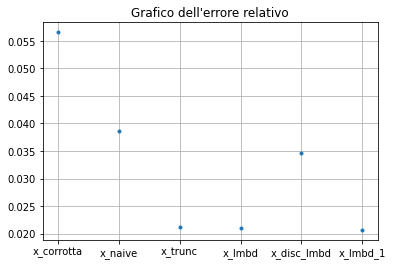

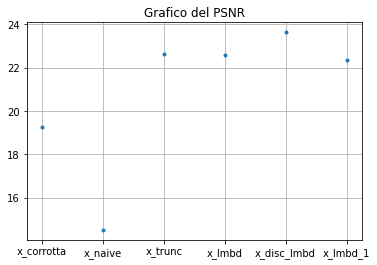

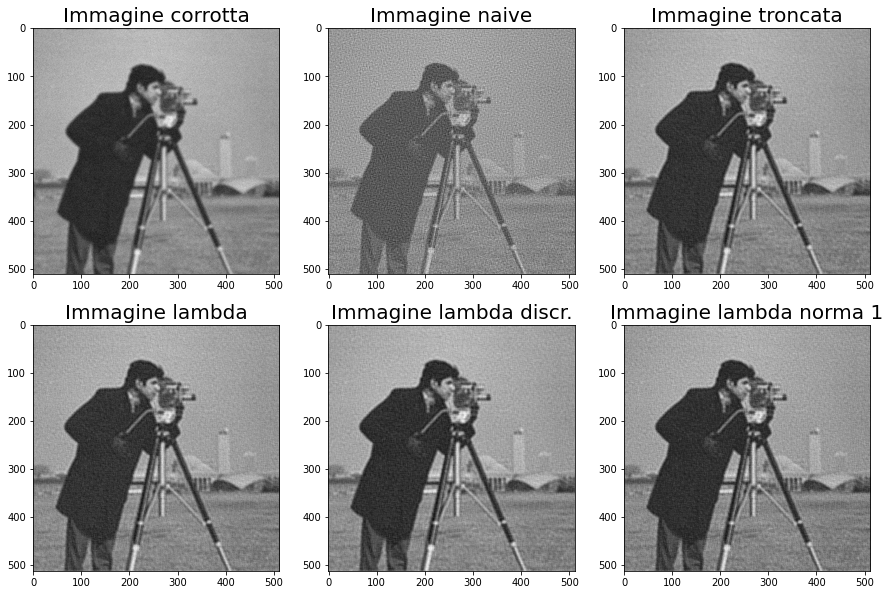

In [ ]:
# Grafici dei valori ottenuti

x_plot = ['x_corrotta', 'x_naive', 'x_trunc', 'x_lmbd', 'x_disc_lmbd', 'x_lmbd_1']
y1 = [err_rel(X, x_init), err_rel(X, x_naive), err_rel(X, x_trunc), err_rel(X, x_lmbd), err_rel(X, x_disc_lmbd), err_rel(X, x_lmbd_1)]
y2 = [psnr(X, x_init), psnr(X, x_naive), psnr(X, x_trunc), psnr(X, x_lmbd), psnr(X, x_disc_lmbd), psnr(X, x_lmbd_1)]

print('Errore relativo')
for i in range(0, 6):
  if i == 1 or i == 2 or i == 3:
    tabulation = '\t\t'
  else:
    tabulation = '\t'
  print(x_plot[i] + tabulation + str(y1[i]))
print('\n')
print('PSNR')
for i in range(0, 6):
  if i == 1 or i == 2 or i == 3:
    tabulation = '\t\t'
  else:
    tabulation = '\t'
  print(x_plot[i] + tabulation + str(y2[i]))
print('\n')

plt.plot(x_plot, y1, marker='.', linestyle=' ')
plt.grid()
plt.title('Grafico dell\'errore relativo')
plt.show()

plt.plot(x_plot, y2, marker='.', linestyle=' ')
plt.title('Grafico del PSNR')
plt.grid()
plt.show()

# Confronto dei vari immagini ricostruiti
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 3, 1)
ax1.imshow(x_init, cmap='gray')
plt.title('Immagine corrotta', fontsize=20)

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(x_naive, cmap='gray')
plt.title('Immagine naive', fontsize=20)

ax3 = plt.subplot(2, 3, 3)
ax3.imshow(x_trunc, cmap='gray')
plt.title('Immagine troncata', fontsize=20)

ax4 = plt.subplot(2, 3, 4)
ax4.imshow(x_lmbd, cmap='gray')
plt.title('Immagine lambda', fontsize=20)

ax5 = plt.subplot(2, 3, 5)
ax5.imshow(x_disc_lmbd, cmap='gray')
plt.title('Immagine lambda discr.', fontsize=20)

ax6 = plt.subplot(2, 3, 6)
ax6.imshow(x_lmbd_1, cmap='gray')
plt.title('Immagine lambda norma 1', fontsize=20)

plt.show()

Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

